<a href="https://colab.research.google.com/github/fadillarizalul/thesis-alzheimer/blob/main/thesis_model_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### IMPORT / VIEWING / PREPROCESSING DATASET

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

#import data dari drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!wget --no-check-certificate \
https://github.com/fadillarizalul/thesis-alzheimer/blob/main/dataset/3-classes-alzheimer-20-patients.zip?raw=true \
  -O 3-classes-alzheimer.zip

--2022-09-19 15:02:14--  https://github.com/fadillarizalul/thesis-alzheimer/blob/main/dataset/3-classes-alzheimer-20-patients.zip?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fadillarizalul/thesis-alzheimer/raw/main/dataset/3-classes-alzheimer-20-patients.zip [following]
--2022-09-19 15:02:14--  https://github.com/fadillarizalul/thesis-alzheimer/raw/main/dataset/3-classes-alzheimer-20-patients.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fadillarizalul/thesis-alzheimer/main/dataset/3-classes-alzheimer-20-patients.zip [following]
--2022-09-19 15:02:15--  https://raw.githubusercontent.com/fadillarizalul/thesis-alzheimer/main/dataset/3-classes-alzheimer-20-patients.zip
Resolving raw.githubusercontent.com (raw.githubusercontent

In [4]:
!unzip /content/3-classes-alzheimer.zip

Archive:  /content/3-classes-alzheimer.zip
   creating: 3-classes-alzheimer-20-patients/
   creating: 3-classes-alzheimer-20-patients/AD/
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00001.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00002.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00003.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00004.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00001-00005.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00001.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00002.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00003.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00004.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00002-00005.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00003-00001.jpg  
  inflating: 3-classes-alzheimer-20-patients/AD/img-00003-00002.jpg  
  inflating: 3-classes

In [5]:
import os
 #lokasi direktori dasar
dir_base ='/content/3-classes-alzheimer-20-patients'
os.listdir(dir_base)
print(os.listdir(dir_base))

#hitung jumlah file per direktori
data_cn = len(os.listdir('/content/3-classes-alzheimer-20-patients/CN'))
data_mci = len(os.listdir('/content/3-classes-alzheimer-20-patients/MCI')) 
data_ad = len(os.listdir('/content/3-classes-alzheimer-20-patients/AD')) 

print("Amount of CN class images:", data_cn)
print("Amount of MCI class images:", data_mci)
print("Amount of AD class images:", data_ad)

['AD', 'MCI', 'CN']
Amount of CN class images: 101
Amount of MCI class images: 100
Amount of AD class images: 108


> `DATA AUGMENTATION`

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2
                                   )

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = dir_base,
                                                   target_size = (256,256),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 248 images belonging to 3 classes.


In [8]:
valid_dataset = valid_datagen.flow_from_directory(directory = dir_base,
                                                  target_size = (256,256),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 61 images belonging to 3 classes.


100%|██████████| 5/5 [00:16<00:00,  3.20s/it]


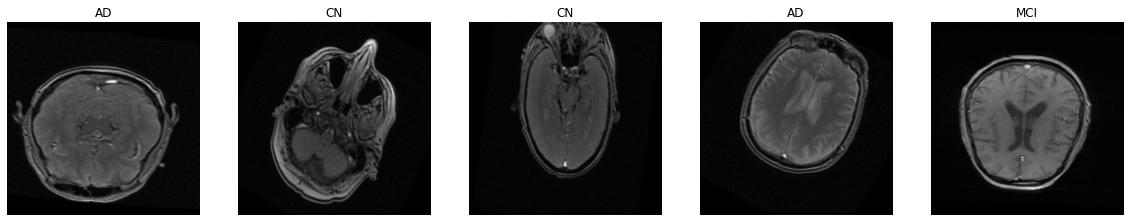

In [9]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('CN')
    elif a[1] == 1:
        ax[i].set_title('MCI')
    elif a[2] == 1:
        ax[i].set_title('AD')

### MODEL BUILDING

In [10]:
# Model Initialization

base_model = DenseNet169(input_shape=(256,256,3), 
                         include_top=False,
                         weights="imagenet")

51888128/51877672 [==============================] - 0s 0us/step


In [11]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [12]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

In [13]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 8, 8, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 8, 8, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 106496)            0         
                                                                 
 batch_normalization (BatchN  (None, 106496)           425984    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              218105856 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [14]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              # metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [20]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 30,
                        # callbacks = earlystopping,
                        verbose = 1)

Epoch 1/30
2/2 [==============================] - 5s 2s/step - loss: 0.3658 - accuracy: 0.8266 - val_loss: 8.4984 - val_accuracy: 0.2787
Epoch 2/30
2/2 [==============================] - 4s 2s/step - loss: 0.4276 - accuracy: 0.8387 - val_loss: 7.4373 - val_accuracy: 0.2787
Epoch 3/30
2/2 [==============================] - 4s 2s/step - loss: 0.3484 - accuracy: 0.8750 - val_loss: 6.6187 - val_accuracy: 0.2787
Epoch 4/30
2/2 [==============================] - 4s 2s/step - loss: 0.4070 - accuracy: 0.8468 - val_loss: 6.4348 - val_accuracy: 0.3115
Epoch 5/30
2/2 [==============================] - 4s 2s/step - loss: 0.3246 - accuracy: 0.8790 - val_loss: 6.7571 - val_accuracy: 0.3115
Epoch 6/30
2/2 [==============================] - 5s 3s/step - loss: 0.2717 - accuracy: 0.9032 - val_loss: 7.4686 - val_accuracy: 0.3115
Epoch 7/30
2/2 [==============================] - 4s 2s/step - loss: 0.2812 - accuracy: 0.8911 - val_loss: 7.9720 - val_accuracy: 0.2623
Epoch 8/30
2/2 [=========================

### MODEL EVALUATION

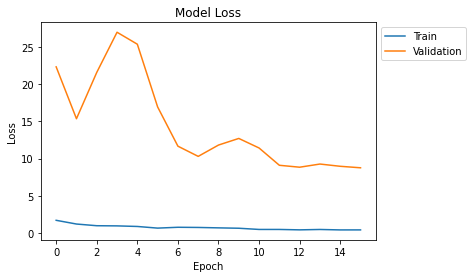

In [17]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

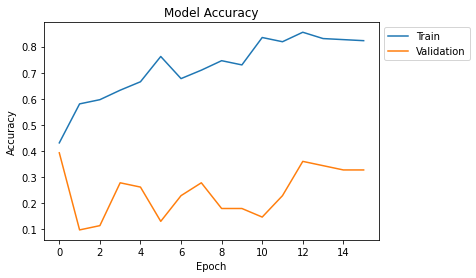

In [19]:
# Summarize history for loss

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [ ]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 4s 448ms/step - loss: 1.2377 - auc: 0.8870


[1.2377309799194336, 0.8869889378547668]

99.93 % chances are there that the image is NonDemented


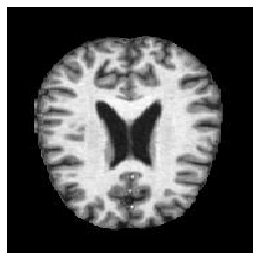

In [ ]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

97.86 % chances are there that the image is MildDemented


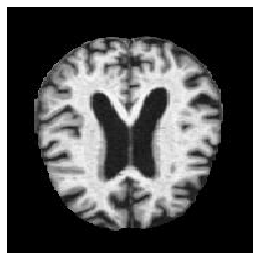

In [ ]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

86.79 % chances are there that the image is ModerateDemented


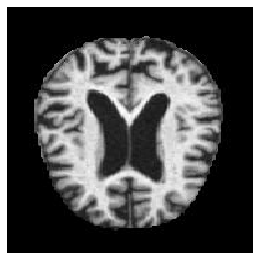

In [ ]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

91.97 % chances are there that the image is VeryMildDemented


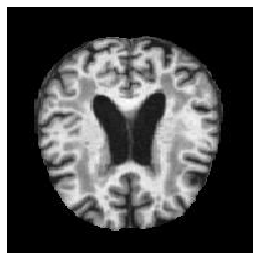

In [ ]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

Conclusion:

So, we have finally built are deep learning model using DenseNet162 transfer learning algorithm and acheived and AUC-90%.